In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import copy
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

from sklearn import tree, svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
writer = SummaryWriter('runs/log')

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [4]:
# %matplotlib inline
%matplotlib qt

In [5]:
from lutils.fin.data_loader import load

In [6]:
df = load('SHFE', 'rb2305')

load Z:/tq_data/ticks\SHFE.rb2305.h5
load Y:/fin_data\2023-05-04\SHFE.rb2305.h5
load Y:/fin_data\2023-05-05\SHFE.rb2305.h5
load Y:/fin_data\2023-05-08\SHFE.rb2305.h5
load Y:/fin_data\2023-05-09\SHFE.rb2305.h5
load Y:/fin_data\2023-05-10\SHFE.rb2305.h5
load Y:/fin_data\2023-05-11\SHFE.rb2305.h5
load Y:/fin_data\2023-05-12\SHFE.rb2305.h5
load Y:/fin_data\2023-05-15\SHFE.rb2305.h5


In [7]:
start_date = '2022-09-01' # '2022-09-01'
end_date = '2023-05-06'

In [8]:
df.index = df.datetime

In [9]:
df = df[start_date:end_date][['last_price', 'volume', 'amount']]

In [10]:
resample_1S = df.resample('1S').last()

In [11]:
resample_1S = resample_1S.interpolate()
# resample_1S = resample_1S.ffill().bfill()

In [12]:
df_1S = pd.concat([resample_1S.between_time('09:00', '10:15'), 
          resample_1S.between_time('10:30', '11:30'),
          resample_1S.between_time('13:30', '15:00'),
          resample_1S.between_time('21:00', '23:00')], axis=0).sort_index()[['last_price', 'volume', 'amount']]

In [13]:
between_times = [['09:00', '10:15'], ['10:30', '11:30'], ['13:30', '15:00'], ['21:00', '23:00']]

In [14]:
start_ix = 300

In [15]:
def prepare_data(df1S):
    
    def _prepare_data(x, window_size):
        # perform windowing
        n_row = x.shape[0] - window_size + 1
        output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0],x.strides[0]))
#         return output[:-1], output[-1]
        return output
    
    dfs_x = []
    dfs_y = []
    for d in tqdm.tqdm(np.unique(df1S.index.date)):
        day1S_df = df1S[df1S.index.date == d]
        for (start, end) in between_times:
            # X
            _df = day1S_df.between_time(start, end)
        
            df_x = _prepare_data(_df.last_price.values, start_ix)
            df_y = np.roll(df_x, start_ix, axis=0)[:-start_ix,:]
        
            y = (df_y[:, 0] - df_y[:, -1]) / (df_y.max(axis=1) - df_y.min(axis=1))
#             y = (df_y[:, -1] - df_y[:, 0]) / df_y[:, 0]
            y[np.isinf(y) | np.isneginf(y)] = 0
            y[np.isnan(y)] = 0
#             y[df_y[:, 0] > df_y[:, -1]] = y[df_y[:, 0] > df_y[:, -1]] * -1
            if y.sum() > 0 and np.abs(y.mean()) != 1:
                dfs_x.append(df_x[:-start_ix])
                dfs_y.append(y)
            
    return dfs_x, dfs_y

In [16]:
dfs_x, dfs_y = prepare_data(df_1S)

100%|████████████████████████████████████████| 247/247 [04:46<00:00,  1.16s/it]


In [17]:
# dfs_x

In [18]:
# dfs_y

In [19]:
len(dfs_x)

327

In [20]:
dfs_x[-1].shape

(3902, 300)

In [21]:
dfs_y[0].shape

(3902,)

In [22]:
end_ix = 300

In [23]:
X = normalize(np.vstack(dfs_x[-end_ix:]), norm='l1')
y = np.hstack(dfs_y[-end_ix:])

In [24]:
# sn.displot(x1[:50], kde=True)

In [25]:
# with open('SHFE.rb2305.npy', 'rb') as f:
#     X = np.load(f)
#     y = np.load(f)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)
X_train = torch.tensor(X_train, dtype=torch.float32, device=0)
y_train = torch.tensor(y_train, dtype=torch.float32, device=0).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32, device=0)
y_test = torch.tensor(y_test, dtype=torch.float32, device=0).reshape(-1, 1)

In [49]:
n_epochs = 40 #100   # number of epochs to run
batch_size = 10  # size of each batch
total_size = X_train.shape[0]
batch_start = torch.arange(0, total_size, batch_size)
batch_test_start = torch.arange(0, len(X_test), batch_size)

In [50]:
class FutureTrendModule(nn.Module):
    def __init__(self):
        super(FutureTrendModule, self).__init__()
        
        # input batch_size 300
        self.fc1 = nn.Sequential(
            nn.Linear(300, 128),
        )
        
        # input batch_size 1 128
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.AvgPool1d(3, 2),
        )
        
        # input batch_size 64 64
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(True),
            nn.AvgPool1d(3, 2),
        )
        
        # input batch_size 32 32
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(True),
            nn.AvgPool1d(3, 2),
        )
        
        # input batch_size 256
        self.output_fc1 = nn.Linear(256, 128)
        # input batch_size 128
        self.output_fc2 = nn.Linear(128, 1)

    def forward(self, x):
#         return self.model(x)
        fc1 = self.fc1(x)
        fc1 = fc1.view(-1, 1, 128)
        conv1 = self.conv1(fc1)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        outs = conv3.view(-1, 256)
        outs = self.output_fc1(outs)
        outs = self.output_fc2(outs)
        return outs, fc1, conv1, conv2, conv3
    

In [54]:
model = FutureTrendModule().to(0)

In [55]:
# loss_fn = nn.MSELoss().to(0)  # mean square error
loss_fn = nn.SmoothL1Loss().to(0)
# loss_fn = nn.CrossEntropyLoss().to(0)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum=0.09)

In [57]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    
    running_loss = 0.0
    for i, start in enumerate(batch_start, 1):
        # take a batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred, fc1, conv1, conv2, conv3 = model(X_batch) # .reshape(-1, 1, 300)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
        
        running_loss += loss.item() * X_batch.shape[0]
        
        step = epoch * len(batch_start) + i
        writer.add_scalar('loss', loss.item(), step)
        
#         writer.add_histogram('fc/fc1', torchvision.utils.make_grid(fc1).data.cpu(), step)
#         writer.add_histogram('conv/conv1', torchvision.utils.make_grid(conv1).data.cpu(), step)
#         writer.add_histogram('conv/conv2', torchvision.utils.make_grid(conv2).data.cpu(), step)
#         writer.add_histogram('conv/conv3', torchvision.utils.make_grid(conv3).data.cpu(), step)
        # add_histogram
        
        if i % 5000 == 0:
            writer.add_histogram('deep/01_x', torchvision.utils.make_grid(X_batch).data.cpu(), step)
            
            writer.add_histogram('deep/02_fc1', torchvision.utils.make_grid(fc1).data.cpu(), step)
            writer.add_histogram('deep/03_conv1', torchvision.utils.make_grid(conv1).data.cpu(), step)
            writer.add_histogram('deep/04_conv2', torchvision.utils.make_grid(conv2).data.cpu(), step)
            writer.add_histogram('deep/05_conv3', torchvision.utils.make_grid(conv3).data.cpu(), step)
            
            writer.add_histogram('deep/09_pred', torchvision.utils.make_grid(y_pred).data.cpu(), step)
            
            print('Epoch: [{}/{}], [{}/{}], Loss: {:.6f}'.format(epoch + 1, n_epochs, start+10, total_size, running_loss / (X_batch.shape[0] * i)))
            
    # evaluate accuracy at end of each epoch
    model.eval()
    eval_loss = 0.0
    for i, start in enumerate(batch_test_start, 1):
        X_batch_test = X_test[start:start+batch_size]
        y_batch_test = y_test[start:start+batch_size]
        
        y_pred, fc1, conv1, conv2, conv3 = model(X_batch_test)
        loss = loss_fn(y_pred, y_batch_test).cpu().detach().numpy()
        
        eval_loss += loss.item() * X_batch_test.shape[0]
    
    eval_loss = eval_loss / X_test.shape[0]
    print('eval loss {:.6f}'.format(eval_loss))
    history.append(eval_loss)
    if eval_loss < best_mse:
        best_mse = eval_loss
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch: [1/40], [50000/944159], Loss: 0.136692
Epoch: [1/40], [100000/944159], Loss: 0.140987
Epoch: [1/40], [150000/944159], Loss: 0.143486
Epoch: [1/40], [200000/944159], Loss: 0.142954
Epoch: [1/40], [250000/944159], Loss: 0.139079
Epoch: [1/40], [300000/944159], Loss: 0.139531
Epoch: [1/40], [350000/944159], Loss: 0.140545
Epoch: [1/40], [400000/944159], Loss: 0.140042
Epoch: [1/40], [450000/944159], Loss: 0.139031
Epoch: [1/40], [500000/944159], Loss: 0.139065
Epoch: [1/40], [550000/944159], Loss: 0.139432
Epoch: [1/40], [600000/944159], Loss: 0.139689
Epoch: [1/40], [650000/944159], Loss: 0.138394
Epoch: [1/40], [700000/944159], Loss: 0.138649
Epoch: [1/40], [750000/944159], Loss: 0.138385
Epoch: [1/40], [800000/944159], Loss: 0.137842
Epoch: [1/40], [850000/944159], Loss: 0.137205
Epoch: [1/40], [900000/944159], Loss: 0.136600
eval loss 0.143371
Epoch: [2/40], [50000/944159], Loss: 0.135929
Epoch: [2/40], [100000/944159], Loss: 0.140387
Epoch: [2/40], [150000/944159], Loss: 0.142

KeyboardInterrupt: 

In [58]:
y_pred

tensor([[0.0941],
        [0.0941],
        [0.0941],
        [0.0941],
        [0.0941],
        [0.0941],
        [0.0941],
        [0.0941],
        [0.0941],
        [0.0941]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
torch.save(model.state_dict(), 'model1.pt')

In [29]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

MSE: 0.14
RMSE: 0.38


In [16]:
np.array(history)

array([0., 0., 0.], dtype=float32)

In [25]:
# price_data = df.close
price_data = df_1T.last_price.diff(1).fillna(0)

<AxesSubplot:xlabel='last_price', ylabel='Count'>

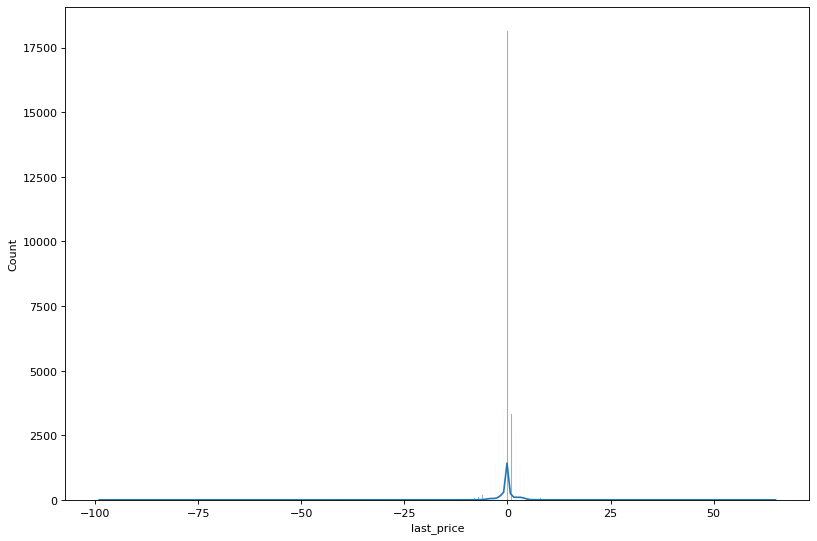

In [27]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
sn.histplot(price_data, kde=True, ax=ax)

In [31]:
config = {
#     "alpha_vantage": {
#         "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
#         "symbol": "IBM",
#         "outputsize": "full",
#         "key_adjusted_close": "5. adjusted close",
#     },
    'symbol': 'rb2305',
    "data": {
        "window_size": 30,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 400,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [32]:
num_data_points = df_1T.shape[0]

In [33]:
data_close_price = price_data.to_numpy()

In [34]:
data_date = df_1T.index.strftime('%Y-%m-%d %H-%M').to_list()
# data_date.reverse()

In [35]:
display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]

In [37]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(price_data.to_numpy())

D:\Software\Python\torch\lib\site-packages\ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


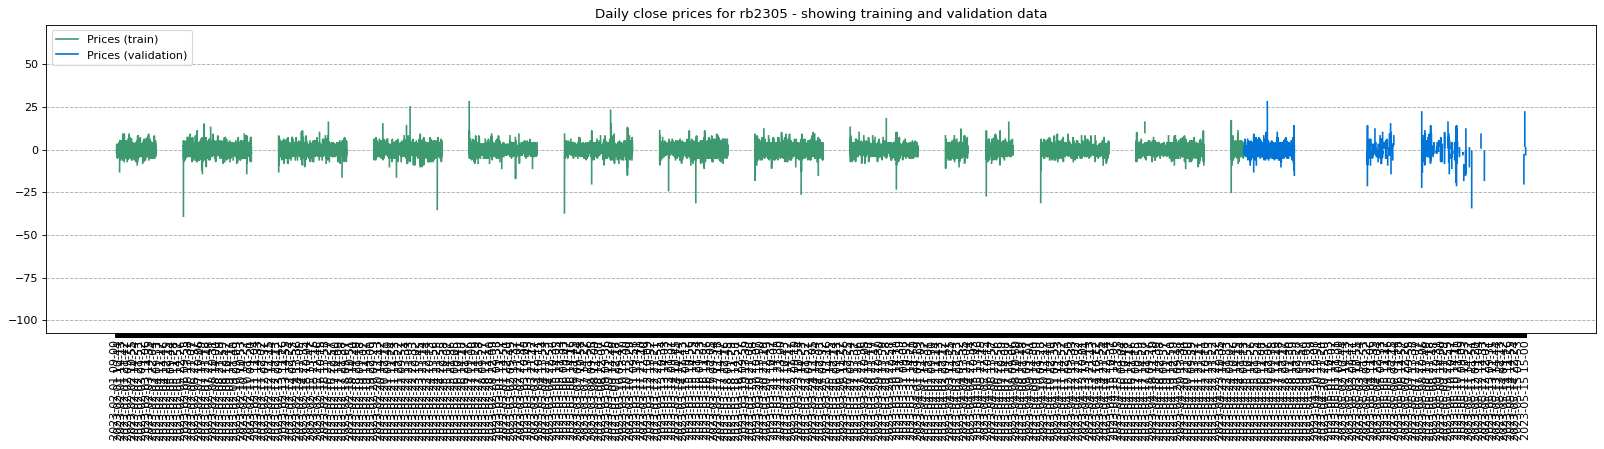

In [38]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["symbol"] + " - showing training and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=True)

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (28916, 30, 1) (28916,)
Validation data shape (7229, 30, 1) (7229,)


In [40]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])